In [1]:
from fastai.vision.all import *
from fastaudio.all import *
from fastai.text.all import *

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/torchaudio/backend/utils.py:46: UserWarning: "torchaudio.USE_SOUNDFILE_LEGACY_INTERFACE" flag is deprecated and will be removed in 0.9.0. Please remove the use of flag.
  warnings.warn(


In [2]:
import editdistance
from fastai.callback.wandb import *

In [3]:
path = Path('../')

In [4]:
import romkan

In [5]:
table = {k:g for (k,g) in zip(["か゚","く゚","け゚","き゚",'こ゚', 'カ゚','ク゚','ケ゚','キ゚','コ゚'], 'がぐげぎごがぐげぎご')}

In [6]:
def convert_to_voiced(kana):
    for key,value in table.items():
        kana = kana.replace(key,value)
    return kana

In [7]:
convert_to_voiced('か゚')

'が'

In [8]:
labels = pd.read_csv('../training.csv', index_col=0)

In [9]:
labels.kana = labels.kana.map(convert_to_voiced)

In [10]:
labels.kana = labels.kana.map(romkan.to_hepburn)

In [11]:
labels.kana = labels.kana.map(romkan.to_katakana)

In [12]:
labels.kana = labels.kana.map(romkan.to_hepburn)

In [13]:
words = L(labels.kana.values.tolist())

In [14]:
whole = ''.join([word for word in words])

In [15]:
whole[:100]

'aruomounadowatakushimirukuruikuyukujibundo-ho-dekirukangaerukangaeruiimotsuwakaruderuokonauyaruyakuw'

In [16]:
vocab = L('',*list(whole))

In [17]:
vocab = vocab.unique()

In [18]:
vocab

(#27) ['','a','r','u','o','m','n','d','w','t'...]

In [19]:
letter2idx = {letter:idx for (idx,letter) in enumerate(vocab)}

In [20]:
letter2idx

{'': 0,
 'a': 1,
 'r': 2,
 'u': 3,
 'o': 4,
 'm': 5,
 'n': 6,
 'd': 7,
 'w': 8,
 't': 9,
 'k': 10,
 's': 11,
 'h': 12,
 'i': 13,
 'y': 14,
 'j': 15,
 'b': 16,
 '-': 17,
 'e': 18,
 'g': 19,
 'p': 20,
 'z': 21,
 'c': 22,
 'f': 23,
 "'": 24,
 'x': 25,
 ' ': 26}

In [21]:
splits = ColSplitter()(labels)
aud2spec = AudioToSpec.from_cfg(AudioConfig.Voice(f_min=0))

In [22]:
labels

,path,pattern,kana,morae,drop,type,is_valid
0,pitch_accent/accentAudio/ある.yomi000142BB_0596.mp3,atamadaka,aru,2,1,nhk,False
1,pitch_accent/accentAudio/思う.yomi0006C617_043A.mp3,nakadaka,omou,3,2,nhk,False
2,pitch_accent/accentAudio/など.yomi000240B7_0028.mp3,atamadaka,nado,2,1,nhk,False
3,pitch_accent/accentAudio/私.yomi00092F63_0072.mp3,heiban,watakushi,4,0,nhk,False
4,pitch_accent/accentAudio/見る.yomi000A41BD_001E.mp3,atamadaka,miru,2,1,nhk,False
...,...,...,...,...,...,...,...
163962,pitch_accent/OjadMedia/立て-377_10_1_female.mp3,atamadaka,tate,2,1,ojad female,False
163963,pitch_accent/OjadMedia/立てる-377_11_1_male.mp3,nakadaka,tateru,3,2,ojad male,True
163964,pitch_accent/OjadMedia/立てる-377_11_1_female.mp3,nakadaka,tateru,3,2,ojad female,False
163965,pitch_accent/OjadMedia/立とう-377_12_1_male.mp3,nakadaka,tatou,3,2,ojad male,True


In [23]:
x_tfms = [lambda x: x[0], lambda x1: path/x1, AudioTensor.create,
          Resample(16_000), RemoveSilence(), ResizeSignal(2000)]
y_tfms = [lambda y: y["kana"], lambda y1: TensorText([letter2idx[i] for i in y1])]
dsets = Datasets(labels, [x_tfms, y_tfms], splits = splits)
dsets

(#160763) [(AudioTensor([[0., 0., 0.,  ..., 0., 0., 0.]]), TensorText([1, 2, 3])),(AudioTensor([[0., 0., 0.,  ..., 0., 0., 0.]]), TensorText([4, 5, 4, 3])),(AudioTensor([[0., 0., 0.,  ..., 0., 0., 0.]]), TensorText([6, 1, 7, 4])),(AudioTensor([[0., 0., 0.,  ..., 0., 0., 0.]]), TensorText([ 8,  1,  9,  1, 10,  3, 11, 12, 13])),(AudioTensor([[0., 0., 0.,  ..., 0., 0., 0.]]), TensorText([ 5, 13,  2,  3])),(AudioTensor([[0., 0., 0.,  ..., 0., 0., 0.]]), TensorText([10,  3,  2,  3])),(AudioTensor([[0., 0., 0.,  ..., 0., 0., 0.]]), TensorText([13, 10,  3])),(AudioTensor([[0., 0., 0.,  ..., 0., 0., 0.]]), TensorText([14,  3, 10,  3])),(AudioTensor([[0., 0., 0.,  ..., 0., 0., 0.]]), TensorText([15, 13, 16,  3,  6])),(AudioTensor([[0., 0., 0.,  ..., 0., 0., 0.]]), TensorText([ 7,  4, 17]))...]

In [24]:
class SqueezeSpec(Transform):
    def encodes(self, x:AudioSpectrogram): return x.squeeze()#.cuda()

In [25]:
dls = dsets.dataloaders(before_batch = Pad_Chunk(0), after_batch=[aud2spec, SqueezeSpec()])
b = dls.one_batch()

In [58]:
class NonSeparableQuartzSubblock(Module):
    r"A basic building sub-block of Quartznet with non-separable Conv layers"
    
    def __init__(self, in_channels, out_channels, kernel, stride, drop = 0.2, **kwargs):
        self.conv = nn.Conv1d(in_channels, out_channels, kernel, stride, (kernel-1)//2, **kwargs)
        self.norm = nn.BatchNorm1d(out_channels)
        self.act = nn.ReLU()
        self.drop = nn.Dropout(drop)
        
    def forward(self, x, res = 0):
        x = self.conv(x)
        x = self.norm(x)
        if not isinstance(res, int): x += res
        x = self.act(x)
        return self.drop(x)
    
    
class QuartzSubblock(Module):
    r"A basic building sub-block of QuartzNet with separable convolutions"
    
    def __init__(self, in_channels, out_channels, kernel, stride, drop = 0.2, **kwargs):
        self.conv = nn.Sequential(nn.Conv1d(in_channels, in_channels, kernel, stride, (kernel-1)//2, groups=in_channels, **kwargs),
                                 nn.Conv1d(in_channels, out_channels, 1, 1))
        self.norm = nn.BatchNorm1d(out_channels)
        self.act = nn.ReLU()
        self.drop = nn.Dropout(drop)
        
    def forward(self, x, res = 0):
        x = self.conv(x)
        x = self.norm(x)
        if not isinstance(res, int): x += res
        x = self.act(x)
        return self.drop(x)
    
class QuartzBlock(Module):
    
    def __init__(self, in_channels, out_channels, kernel, num_subblocks=3, drop = 0.2):
        self.subblocks = nn.Sequential(*[QuartzSubblock(in_channels, out_channels, kernel, 1, drop = 0.2)] \
        + [QuartzSubblock(out_channels, out_channels, kernel, 1, drop = 0.2) for i in range(num_subblocks-2)])
        self.res_subblock = QuartzSubblock(out_channels, out_channels, kernel, 1, drop = 0.2)
        self.res_conv = nn.Conv1d(in_channels, out_channels, 1)
        self.res_norm = nn.BatchNorm1d(out_channels)
        
    def forward(self, x):
        x, res = self.subblocks(x), self.res_conv(x)
        x = self.res_subblock(x, self.res_norm(x))
        return x
    
class QuartzNet(Module):
    
    def __init__(self, n_mels, n_vocab, num_blocks_factor=2, num_subblocks = 5):
        KERNELS = [33, 39, 51, 63, 75]
        OUTS = [256, 256, 512, 512, 512, 256]
        DROPS = [0.2]*3 + [0.3]*2
        
        self.model = nn.Sequential(*[NonSeparableQuartzSubblock(n_mels, 256, 33, 2)] \
        + [QuartzBlock((OUTS[i], OUTS[i-1])[j==0], OUTS[i], KERNELS[i], num_subblocks, DROPS[i])
           for i in range(5) for j in range(num_blocks_factor)] \
        + [QuartzSubblock(OUTS[-2], 512, 87, 1, 0.4)],
          NonSeparableQuartzSubblock(512, 1024, 1, 1, 0.4, dilation=2),
        nn.Conv1d(1024, n_vocab, 1),
                                   nn.LogSoftmax(1)
        )
        
    def forward(self, x):
        return self.model(x)

In [59]:
model = QuartzNet(b[0].shape[1], len(vocab), 3).cuda()

In [28]:
b[0].shape

torch.Size([64, 128, 251])

In [29]:
x,y = b

In [30]:
y.shape

torch.Size([64, 21])

In [31]:
out = model(x)
out.shape

torch.Size([64, 27, 126])

In [32]:
out[0,:,1]

AudioSpectrogram([-3.3543, -3.1536, -3.2183, -3.4028, -3.3633, -3.3709, -3.2839, -3.0815,
        -3.3674, -3.4833, -3.2797, -3.2255, -3.2344, -3.4390, -3.2782, -3.2472,
        -3.3683, -3.3711, -3.1561, -3.3254, -3.3262, -3.3659, -3.2991, -3.2544,
        -3.2734, -3.2799, -3.2900], device='cuda:0', grad_fn=<AliasBackward>)

In [33]:
out_rear =  torch.einsum("ijk->kij",out).cpu()
out_l = torch.full(fill_value = out_rear.shape[0], size = (out_rear.shape[1],) ).cpu()
y_l = torch.full(fill_value = y.shape[1], size = (y.shape[0],)).cpu()

In [34]:
out_rear.shape

torch.Size([126, 64, 27])

In [35]:
loss = nn.CTCLoss()(Tensor(out_rear), y, out_l, y_l)
loss

TensorText(15.8941, grad_fn=<AliasBackward>)

In [36]:
loss.backward()

In [37]:
CTC = nn.CTCLoss()
def ctc_loss_no_lens(preds, targs):
    preds = Tensor(torch.einsum("ijk->kij",preds).cpu())
    preds_l = torch.full(fill_value = preds.shape[0], size = (preds.shape[1],) )#.cpu()
    targs_l = torch.full(fill_value = targs.shape[1], size = (targs.shape[0],))#.cpu()
    return CTC(preds, targs, preds_l, targs_l)

In [38]:
ctc_loss_no_lens(out, y)

TensorText(15.8941, grad_fn=<AliasBackward>)

In [39]:
out.shape

torch.Size([64, 27, 126])

In [40]:
out.argmax(1).shape

torch.Size([64, 126])

In [41]:
def unpad(text):
    return Pad_Chunk(0).decode(text)

def ctc_decode(pred, empid = 0):
    pred = pred.argmax(0)
    dec = [empid]
    for i in range(len(pred)):
        cur = int(pred[i])
        if cur != dec[-1]: dec.append(cur)
    return [i for i in dec if i!=0]

def ids_to_str(ids):
    return ''.join([vocab[i] for i in ids])

In [42]:
def CER(inp, targ):
    bs = inp.shape[0]
    cer = 0
    for i,t in zip(inp,targ):
        i = ids_to_str(ctc_decode(i))
        t = ids_to_str(unpad(t))
        cer += editdistance.eval(i,t)/len(t)
    return cer / bs * 100

In [43]:
def ctc_accuracy(inp, targ):
    bs = inp.shape[0]
    cer = 0
    for i,t in zip(inp,targ):
        i = ids_to_str(ctc_decode(i))
        t = ids_to_str(unpad(t))
        cer += i==t
    return cer / bs

In [44]:
out.shape

torch.Size([64, 27, 126])

In [45]:
CER(out,y)

1234.276413690476

In [46]:
ctc_accuracy(out,y)

0.0

In [47]:
accuracy??

Signature: accuracy(inp, targ, axis=-1)
Source:   
def accuracy(inp, targ, axis=-1):
    "Compute accuracy with `targ` when `pred` is bs * n_classes"
    pred,targ = flatten_check(inp.argmax(dim=axis), targ)
    return (pred == targ).float().mean()
File:      ~/.conda/envs/default/lib/python3.9/site-packages/fastai/metrics.py
Type:      function


In [48]:
import wandb

In [49]:
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: mizoru (use `wandb login --relogin` to force relogin)


True

In [60]:
wandb.init()

wandb: wandb version 0.12.11 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [61]:
learn = Learner(dls, model, loss_func=ctc_loss_no_lens, metrics = [CER, ctc_accuracy],
                cbs=[WandbCallback(), SaveModelCallback()])

SuggestedLRs(valley=0.009999999776482582)

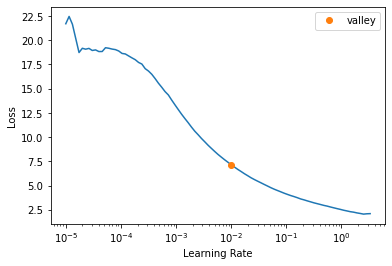

In [62]:
learn.lr_find(1e-5, 10)

In [63]:
learn.fit_one_cycle(3, 1e-1)

epoch,train_loss,valid_loss,CER,ctc_accuracy,time


KeyboardInterrupt: 

In [64]:
wandb.finish()

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
eps_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr_0,▁▁▁▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
mom_0,████████▇▇▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁▁▁
raw_loss,▅▄▅▆▅█▅▄▂▅▂▄▆▄▇▃▄▃▃▄▅▃▄▃▅▅▃▂▁▄▃▇▄▃▁▁▅▂▆▃
sqr_mom_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▄▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wd_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,0.66126
eps_0,1e-05
lr_0,0.09668


In [171]:
learn.save('QuartzNet')

Path('models/Jasper.pth')

In [65]:
pred = learn.model(x)

In [66]:
pred[0].shape

torch.Size([27, 126])

In [67]:
[''.join([vocab[i] for i in pred[j].argmax(0)]) for j in range(64)]

['kaa',
 'ksa',
 'kaaa',
 'kaasa',
 'aasa',
 'kaa',
 'asa',
 'kaaa',
 'aasa',
 'kaa',
 'aaa',
 'kaaa',
 'aasa',
 'kaaa',
 'kasa',
 'aaa',
 'aaa',
 'kaaa',
 'kaa',
 'aa',
 'asa',
 'asa',
 'kaosa',
 'aa',
 'asaa',
 'asa',
 'kaa',
 'aa',
 'a',
 'kasa',
 'kaa',
 'koa',
 'kaaa',
 'kaasa',
 'oasa',
 'kaa',
 'asa',
 'kaa',
 'aasa',
 'koaa',
 'aa',
 'kaasa',
 'kaka',
 'asa',
 'kaasa',
 'aasa',
 'kaaa',
 'aa',
 'aa',
 'aa',
 'asa',
 'a',
 'aasa',
 'aaa',
 'aa',
 'aaa',
 'aaa',
 'kakaa',
 'ka',
 'kaaa',
 'kaasa',
 'kaaa',
 'kaa',
 'kaa']

In [82]:
def unpad(text):
    return Pad_Chunk(0).decode(text)

def ctc_decode(pred, empid = 0):
    pred = pred.argmax(0)
    dec = [empid]
    for i in range(len(pred)):
        cur = int(pred[i])
        if cur != dec[-1]: dec.append(cur)
    return [i for i in dec if i!=0]

def ids_to_str(ids):
    return ''.join([vocab[i] for i in ids])

In [ ]:
ctc_decode(pred[0])

In [83]:
preds,targs = learn.get_preds()

In [90]:
[ids_to_str(ctc_decode(preds[i])) for i in range(64,128)]

['',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '']

In [87]:
print('prediction', 'target', sep='\t')
print()
for i in range(1000,1100):
    print(*[ids_to_str(i) for i in (ctc_decode(preds[i]), unpad(targs[i]))], sep='\t\t')

prediction	target

		kiru
		kirimasu
		kitte
		kitta
		kiranai
		kiranakatta
		kireba
		kiraseru
		kirareru
		kire
		kireru
		kirou
		erabu
		erabimasu
		erande
		eranda
		erabanai
		erabanakatta
		erabeba
		erabaseru
		erabareru
		erabe
		eraberu
		erabou
		riyousuru
		riyoushimasu
		riyoushite
		riyoushita
		riyoushinai
		riyoushinakatta
		riyousureba
		riyousaseru
		riyousareru
		riyoushiro
		riyoudekiru
		riyoushiyou
		motoduku
		motodukimasu
		motoduite
		motoduita
		motodukanai
		motodukanakatta
		motodukeba
		motodukaseru
		motodukareru
		motoduke
		motodukou
		noberu
		nobemasu
		nobete
		nobeta
		nobenai
		nobenakatta
		nobereba
		nobesaseru
		noberareru
		nobero
		noberareru
		nobeyou
		kimeru
		kimemasu
		kimete
		kimeta
		kimenai
		kimenakatta
		kimereba
		kimesaseru
		kimerareru
		kimero
		kimerareru
		kimeyou
		tsudukeru
		tsudukemasu
		tsudukete
		tsuduketa
		tsudukenai
		tsudukenakatta
		tsudukereba
		tsudukesaseru
		tsudukerareru
		tsudukero
		tsudukerareru
		tsudukeyo

In [86]:
preds[0, :, 3]

AudioSpectrogram([-0.9940, -3.0548, -3.4349, -3.0396, -3.3838, -3.4011, -3.5963, -4.0333,
        -5.6006, -3.0469, -2.9385, -2.9775, -3.1846, -2.8040, -3.7666, -4.9258,
        -4.8998, -3.6197, -3.4029, -4.6347, -5.6210, -5.1322, -4.9652, -5.8269,
        -5.7516, -6.3390, -6.6762])

In [268]:
Jasper(128, 27).cuda()(x)

Error in callback <function _WandbInit._resume_backend at 0x7f620c9edf70> (for pre_run_cell):


Exception: The wandb backend process has shutdown

AudioSpectrogram([[[0.0388, 0.0426, 0.0536,  ..., 0.0410, 0.0411, 0.0697],
         [0.0289, 0.0319, 0.0428,  ..., 0.0407, 0.0467, 0.0414],
         [0.0422, 0.0295, 0.0455,  ..., 0.0390, 0.0377, 0.0361],
         ...,
         [0.0510, 0.0505, 0.0312,  ..., 0.0570, 0.0590, 0.0735],
         [0.0339, 0.0365, 0.0271,  ..., 0.0374, 0.0543, 0.0359],
         [0.0413, 0.0429, 0.0271,  ..., 0.0395, 0.0348, 0.0300]],

        [[0.0486, 0.0286, 0.0308,  ..., 0.0315, 0.0478, 0.0269],
         [0.0568, 0.0362, 0.0392,  ..., 0.0333, 0.0468, 0.0203],
         [0.0428, 0.0502, 0.0252,  ..., 0.0566, 0.0369, 0.0353],
         ...,
         [0.0302, 0.0487, 0.0319,  ..., 0.0715, 0.0452, 0.0179],
         [0.0557, 0.0565, 0.0468,  ..., 0.0321, 0.0249, 0.0676],
         [0.0447, 0.0256, 0.0385,  ..., 0.0255, 0.0662, 0.0268]],

        [[0.0551, 0.0555, 0.0322,  ..., 0.0821, 0.0781, 0.0199],
         [0.0716, 0.0241, 0.0227,  ..., 0.0556, 0.0304, 0.0290],
         [0.0232, 0.0404, 0.0641,  ..., 0.0736, 

Error in callback <function _WandbInit._pause_backend at 0x7f620c99b4c0> (for post_run_cell):


Exception: The wandb backend process has shutdown